## Predicting Credit Card Spend & Identifying Key Drivers

One of the global banks would like to understand what factors driving credit card spend are. The bank wants to use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.

**Data Availability**

-Data for the case are available in xlsx format(Data Set.xlxs).

-The data have been provided for 5000 customers.

-Detailed data dictionary has been provided for understanding the data in the data.

-Data is encoded in the numerical format to reduce the size of the data however some of the variables are categorical. You can find the details in the data dictionary

**Business Problem**	

-The objective of this case study is to understand what's driving the total spend of credit card(Primary Card + Secondary card)	

-Priotize the drivers based on the importance. 	


In [1]:
# Importing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import pylab
import scipy.stats as stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### UDF

In [2]:
# Use a general function that returns multiple values
def continuous_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), 
                      x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),
                      x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), 
                      x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,
                         'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), x.nunique(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'NUNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Handling Outliers for numerical data
def outlier_capping(x):
    x = x.clip(upper= x.quantile(0.99), lower= x.quantile(0.01))
    return x

In [5]:
def missing_impute(x, stats = 'mean'):
    if (x.dtypes == 'float64')|(x.dtypes=='int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode()[0])
    return x

In [6]:
def dummy(df,colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df,col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

### Importing data

In [7]:
#data_dic = pd.read_excel("Data Dictionary.xlsx")
data = pd.read_excel("Data Set.xlsx")

In [8]:
data.head(2)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0


### Data Analysis

In [9]:
# Checking column and their data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [10]:
data.duplicated().value_counts()

False    5000
dtype: int64

## Data Preparation (Determining Assumptions)

### Creating Dependent Y column

In [11]:
# According to our given problem we have to add cardspent and card2spent
data['total_spent'] = data['cardspent'] + data['card2spent']

In [12]:
# Dropping cardspent and card2spent
data.drop(['cardspent','card2spent'], axis=1, inplace=True)

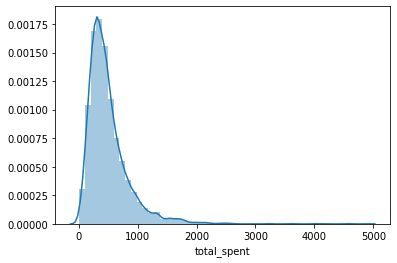

Skewness: 2.707546987697521


In [13]:
sns.distplot(data.total_spent)
plt.show()
print("Skewness:", data.total_spent.skew())

#### Y-variable is right skewed, performming log transformation to make it normally skewed (first assumption for Linear Regression) 

In [14]:
data['total_spent'] = data['total_spent'].clip(upper= data['total_spent'].quantile(0.99), 
                                               lower= data['total_spent'].quantile(0.01))

In [15]:
data['ln_total_spent'] = np.log(data['total_spent'])

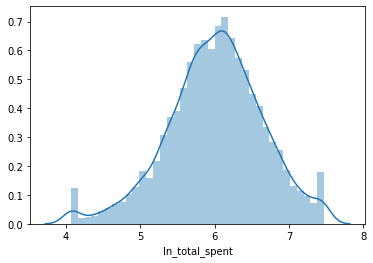

Skewness: -0.30005358806310334


In [16]:
sns.distplot(data.ln_total_spent)
plt.show()
print("Skewness:", data.ln_total_spent.skew())

In [17]:
data.select_dtypes(include='number').apply(continuous_summary).round(1)    

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spent,ln_total_spent
N,5000.0,4998.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
NMISS,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MEAN,3.0,2.7,0.5,47.0,4.2,14.5,2.7,2.8,0.2,9.7,...,0.6,0.5,0.5,0.2,0.5,0.1,0.1,0.1,493.4,6.0
MEDIAN,3.0,3.0,1.0,47.0,4.0,14.0,2.0,2.0,0.0,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414.2,6.0
STD,1.4,1.4,0.5,17.8,1.3,3.3,1.2,1.7,0.4,9.7,...,0.5,0.5,0.5,0.4,0.5,0.3,0.3,0.3,322.8,0.6
VAR,2.0,2.0,0.3,315.8,1.7,10.8,1.5,3.0,0.1,93.9,...,0.2,0.2,0.2,0.1,0.2,0.1,0.1,0.1,104196.8,0.4
MIN,1.0,1.0,0.0,18.0,2.0,6.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.2,4.1
P1,1.0,1.0,0.0,18.0,2.0,8.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.2,4.1
P5,1.0,1.0,0.0,20.0,2.0,9.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.1,4.9
P10,1.0,1.0,0.0,23.0,2.0,10.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184.0,5.2


In [18]:
data.loc[:,data.dtypes == 'object'].apply(categorical_summary).T

,N,NMISS,NUNIQUE,MODE,FREQ,PERCENT
custid,5000,0,5000,9081-UBQDSR-6IK,1,0.02
birthmonth,5000,0,12,September,458,9.16


### Data Related Assumption

In [19]:
# Droping column 'custid' - Showing high cardinality
data.drop(['custid'], axis=1, inplace=True)

# Droping column 'birthmonth' - Not adding any value addition to the dependent variable.
data.drop(['birthmonth'], axis=1, inplace=True) 

In [20]:
# townsize is ordinal type therefore changing it in ascending order
data.townsize.replace([5,4,3,2,1], [1,2,3,4,5], inplace=True)

#### Treating negative values as missing and impute them. 

In [21]:
data[['carown','cartype','carcatvalue','carbought','carvalue','spoused','spousedcat']].min()

carown        -1.0
cartype       -1.0
carcatvalue   -1.0
carbought     -1.0
carvalue      -1.0
spoused       -1.0
spousedcat    -1.0
dtype: float64

* 'carown', 'cartype', 'carbought', 'carcatvalue', 'carvalue' : -1(no response) 
* 'spoused','spousedcat' : -1(Not married) 

In [22]:
# imputting -1 (no response) with 0
data[['carown','cartype','carbought','carcatvalue','carvalue']] = data[['carown','cartype','carbought','carcatvalue',
        'carvalue']].where(data[['carown','cartype','carbought','carcatvalue','carvalue']] >= 0, 0)

In [23]:
# imputting -1 (Not married) with 0
data[['spoused','spousedcat']] = data[['spoused','spousedcat']].where(data > 0, 0)

In [24]:
# imputting no response in other features with 0
data['reason'] = data['reason'].apply(lambda x:x if x<=4 else 0)
data['agecat'] = data['agecat'].apply(lambda x:x if x<=6 else 0)

### Dividing the dataset into continuous and categorical

In [25]:
# All catagorical variables from Data Dictionary

all_cat_var = ['active', 'address', 'addresscat', 'agecat', 'bfast', 'birthmonth', 'callcard', 'callid', 'callwait', 
               'carbought', 'carbuy', 'carcatvalue', 'card', 'card2', 'card2benefit', 'card2fee', 'card2tenure', 
               'card2tenurecat', 'card2type', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'cardtype', 'carown', 
               'cars', 'cartype', 'churn', 'commute', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 
               'commutecat', 'commutemotorcycle', 'commutenonmotor', 'commutepublic', 'commuterail', 'commutewalk', 'confer', 
               'default', 'ebill', 'edcat', 'empcat', 'employ', 'equip', 'forward', 'gender', 'homeown', 'hometype', 'inccat', 
               'internet', 'jobcat', 'jobsat', 'marital', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod',
               'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 'polcontrib', 'polparty', 'polview', 'reason', 'region', 
               'response_01', 'response_02', 'response_03', 'retire', 'spousedcat', 'telecommute', 'tollfree', 'townsize', 
               'union', 'voice', 'vote', 'wireless']

all_cat_ordinal = ['addresscat', 'agecat', 'carcatvalue', 'card2tenure', 'card2tenurecat', 'cardtenure', 'cardtenurecat', 
                   'cars', 'edcat', 'empcat', 'employ', 'inccat', 'jobsat', 'spousedcat', 'townsize']

all_cat_nominal = ['active', 'address', 'bfast', 'birthmonth', 'callcard', 'callid', 'callwait', 'carbought', 'carbuy', 'card', 
                   'card2', 'card2benefit', 'card2fee', 'card2type', 'cardbenefit', 'cardfee', 'cardtype', 'carown', 'cartype', 
                   'churn', 'commute', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat', 
                   'commutemotorcycle', 'commutenonmotor', 'commutepublic', 'commuterail', 'commutewalk', 'confer', 'default', 
                   'ebill', 'equip', 'forward', 'gender', 'homeown', 'hometype', 'internet', 'jobcat', 'marital', 'multline', 
                   'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 
                   'polcontrib', 'polparty', 'polview', 'reason', 'region', 'response_01', 'response_02', 'response_03', 
                   'retire', 'telecommute', 'tollfree', 'union', 'voice', 'vote', 'wireless']

In [26]:
# Converting catagorical variables into a list.
cat_var = list(set(data.columns).intersection(all_cat_var))

In [27]:
# Converting catagorical variables from numeric to object datatype
data[cat_var] = data[cat_var].astype('object')

In [28]:
# Converting continuous variables into a list.
conti_var = data.select_dtypes(include='number').columns

In [29]:
# Information about numeric variable and catagorical variable
print('continuous dataset shape: ', data[conti_var].shape)
print('catagorical dataset shape: ', data[cat_var].shape)

continuous dataset shape:  (5000, 45)
catagorical dataset shape:  (5000, 83)


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 128 entries, region to ln_total_spent
dtypes: float64(30), int64(15), object(83)
memory usage: 4.9+ MB


In [31]:
data[conti_var].apply(continuous_summary).T.round(1)

,N,NMISS,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,47.0,47.0,17.8,315.8,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
ed,5000.0,0.0,14.5,14.0,3.3,10.8,6.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,23.0
income,5000.0,0.0,54.8,38.0,55.4,3066.7,9.0,9.0,13.0,16.0,24.0,38.0,67.0,109.1,147.0,272.0,1073.0
lninc,5000.0,0.0,3.7,3.6,0.7,0.6,2.2,2.2,2.6,2.8,3.2,3.6,4.2,4.7,5.0,5.6,7.0
debtinc,5000.0,0.0,10.0,8.8,6.4,41.0,0.0,0.7,1.9,2.8,5.1,8.8,13.6,18.6,22.2,29.2,43.1
creddebt,5000.0,0.0,1.9,0.9,3.4,11.7,0.0,0.0,0.1,0.2,0.4,0.9,2.1,4.3,6.4,14.3,109.1
lncreddebt,4999.0,1.0,-0.1,-0.1,1.3,1.6,-6.6,-3.4,-2.3,-1.7,-1.0,-0.1,0.7,1.5,1.9,2.7,4.7
othdebt,5000.0,0.0,3.7,2.1,5.4,29.1,0.0,0.1,0.3,0.5,1.0,2.1,4.3,8.1,11.8,24.1,141.5
lnothdebt,4999.0,1.0,0.7,0.7,1.1,1.3,-4.1,-2.2,-1.2,-0.8,-0.0,0.7,1.5,2.1,2.5,3.2,5.0
spoused,5000.0,0.0,6.6,0.0,7.3,52.8,0.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,18.0,20.0,24.0


In [32]:
data[cat_var].apply(categorical_summary).sort_values(by='PERCENT', axis=1, ascending=False).round(1)

,owntv,commutenonmotor,owncd,response_01,ownvcr,owndvd,commutepublic,response_03,commutemotorcycle,commutebike,...,cardtype,agecat,addresscat,empcat,jobsat,region,employ,card2tenure,cardtenure,address
N,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
NMISS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NUNIQUE,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,5.0,5.0,5.0,5.0,5.0,52.0,31.0,41.0,57.0
MODE,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,4.0,4.0,3.0,2.0,3.0,5.0,0.0,2.0,3.0,0.0
FREQ,4915.0,4708.0,4664.0,4582.0,4578.0,4568.0,4523.0,4487.0,4487.0,4383.0,...,1260.0,1222.0,1221.0,1180.0,1085.0,1027.0,659.0,304.0,246.0,245.0
PERCENT,98.3,94.2,93.3,91.6,91.6,91.4,90.5,89.7,89.7,87.7,...,25.2,24.4,24.4,23.6,21.7,20.5,13.2,6.1,4.9,4.9


### Handling Outliers
**There are some extreme high / low value which need to be rectified so that it will not have impact on our model**

In [33]:
data[conti_var] = data[conti_var].apply(lambda x: outlier_capping(x))

### Handling Missing Values

In [34]:
# Missing values and their percentage
for col in data.columns:
    if int(data[col].isna().sum()) > 0:
        print(col, '\t', round(data[col].isna().sum()), '\t', round(data[col].isna().sum()/len(data) *100))

townsize 	 2 	 0.0
lncreddebt 	 1 	 0.0
lnothdebt 	 1 	 0.0
commutetime 	 2 	 0.0
longten 	 3 	 0.0
lnlongten 	 3 	 0.0
lntollmon 	 2622 	 52.0
lntollten 	 2622 	 52.0
lnequipmon 	 3296 	 66.0
lnequipten 	 3296 	 66.0
lncardmon 	 1419 	 28.0
cardten 	 2 	 0.0
lncardten 	 1422 	 28.0
lnwiremon 	 3656 	 73.0
lnwireten 	 3656 	 73.0


In [35]:
# most of the missing values are in log transformation
log = ['lncardmon','lncardten','lncreddebt','lnequipmon','lnequipten','lninc','lnlongmon','lnlongten','lnothdebt','lntollmon',
     'lntollten','lnwiremon','lnwireten']

# Dropping log function
data.drop(log, axis=1, inplace=True)

In [36]:
# updating continuous variable
conti_var = data.select_dtypes(include='number').columns

In [37]:
for col in data.columns:
    if int(data[col].isna().sum()) > 0:
        print(col, '\t', round(data[col].isna().sum()), '\t', round(data[col].isna().sum()/len(data) *100))

townsize 	 2 	 0.0
commutetime 	 2 	 0.0
longten 	 3 	 0.0
cardten 	 2 	 0.0


In [38]:
# Total number of missing values in continuous and categorical data
print ("Missing values in continuous data:", data[conti_var].isnull().sum().values.sum())
print ("Missing values in categorical data:", data[cat_var].isnull().sum().values.sum())

Missing values in continuous data: 7
Missing values in categorical data: 2


In [39]:
# Imputing numerical missing data with mean() and categorical missing data with mode()
data = data.apply(missing_impute)

In [40]:
# Total number of missing values in continuous and categorical data
print ("Missing values in continuous data:", data[conti_var].isnull().sum().values.sum())
print ("Missing values in categorical data:", data[cat_var].isnull().sum().values.sum())

Missing values in continuous data: 0
Missing values in categorical data: 0


#### Recreating log transformation

In [41]:
# recreating log variable that were deleted by making variable normally distributed by applying log transformation
transform = ['longmon', 'longten', 'tollten', 'tollmon', 'wiremon', 'wireten',  
             'equipmon', 'equipten', 'cardmon', 'cardten', 'income', 'creddebt', 'othdebt']

new_log = []
for i in transform:
    col = 'ln_'+ i
    new_log.append(col)
    data[col] = np.log(data[i]+1)
    
print(new_log)

['ln_longmon', 'ln_longten', 'ln_tollten', 'ln_tollmon', 'ln_wiremon', 'ln_wireten', 'ln_equipmon', 'ln_equipten', 'ln_cardmon', 'ln_cardten', 'ln_income', 'ln_creddebt', 'ln_othdebt']


### EDA

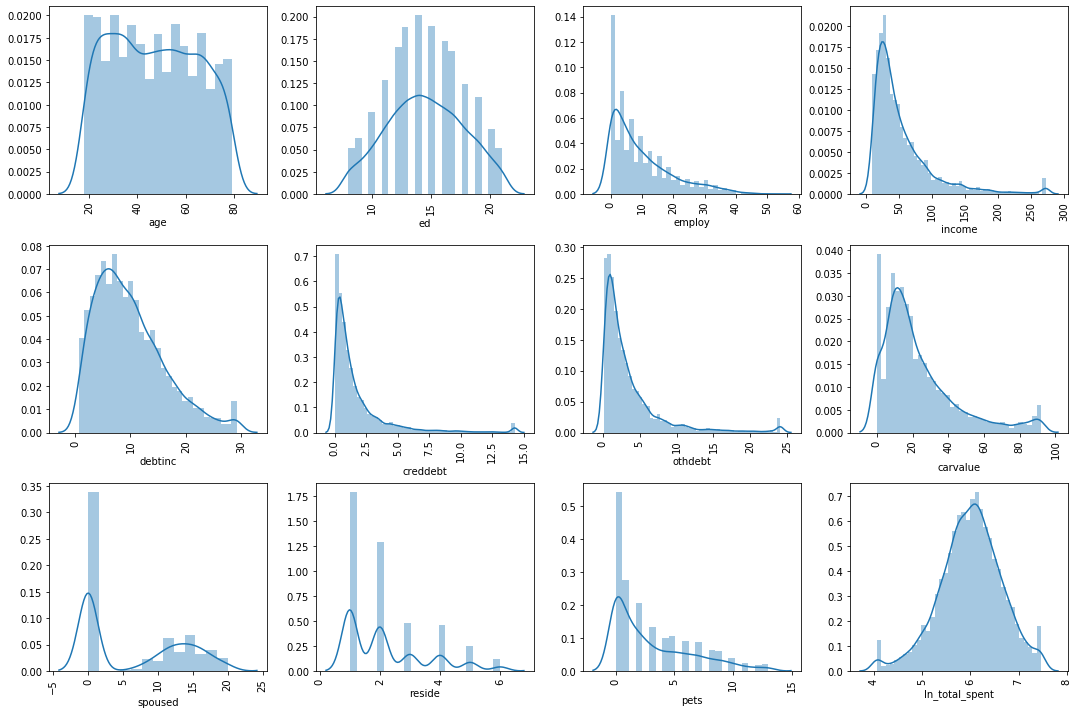

In [42]:
plt_cont_cols = ['age', 'ed', 'employ', 'income', 'debtinc', 'creddebt', 'othdebt', 'carvalue', 'spoused', 'reside', 
                 'pets', 'ln_total_spent']

plt.figure(figsize = (15,10))
for i, col in enumerate(plt_cont_cols):
    plt.subplot(3, 4, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.distplot(data[col])
    plt.xticks(rotation = 90)
    plt.tight_layout()

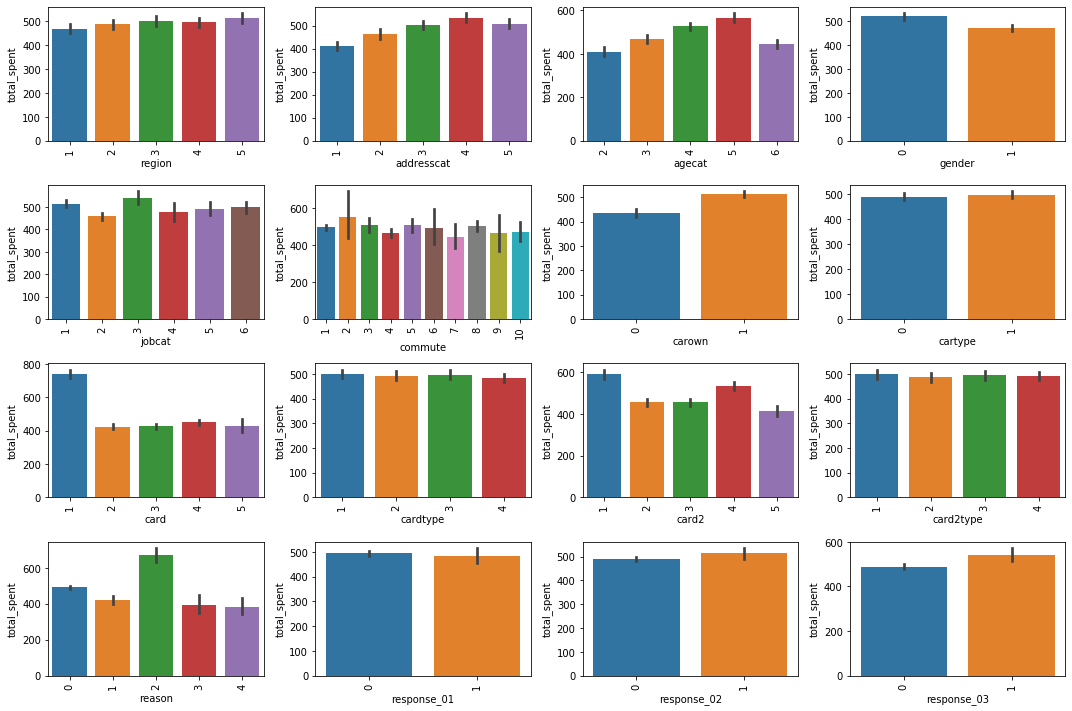

In [43]:
plt_cat_cols = ['region','addresscat','agecat','gender','jobcat','commute','carown','cartype','card','cardtype','card2',
                'card2type','reason','response_01','response_02','response_03']

plt.figure(figsize = (15,10))
for i, col in enumerate(plt_cat_cols):
    plt.subplot(4, 4, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = data[col], y = data.total_spent)
    plt.xticks(rotation = 90)
    plt.tight_layout()

####  Analysis:

- Total Spent is maximum in region 5 
- Male spending is more than female
- Job category 3 has maximum Total Spent
- Total spent is more for those who own a car

- People who bought the card for convenience have high total spent
- American Express card total spent is maximum than card1 and card2
- Total spent for people who commutes by Motorcycle is high
- People with voice mail service have maximum total spent
- Total spent is high for those who uses 'cable modem' and 'other' type of internet services
- Response to product offer 3 is higher

### Dropping the variables based on the data audit report (near zero variance, higly correlated variables)

In [44]:
cor = data.corr()
cor.to_excel('correlation.xlsx')

**Finding the correlation among the X variables**

In [45]:
new_cor = cor.round(2).unstack().reset_index()
new_cor.rename(columns={0:'correlation'}, inplace=True)

In [46]:
high_corr = list(set(new_cor.loc[(abs(new_cor.correlation) > 0.8) & (new_cor.level_0 != new_cor.level_1)].level_0))
high_corr.sort()
print(high_corr)

['address', 'addresscat', 'age', 'agecat', 'callcard', 'carcatvalue', 'card2tenure', 'card2tenurecat', 'cardmon', 'cardten', 'cardtenure', 'cardtenurecat', 'carvalue', 'commute', 'commutecat', 'creddebt', 'ed', 'edcat', 'empcat', 'employ', 'equip', 'equipmon', 'equipten', 'inccat', 'income', 'ln_cardmon', 'ln_cardten', 'ln_creddebt', 'ln_equipmon', 'ln_equipten', 'ln_income', 'ln_longmon', 'ln_longten', 'ln_othdebt', 'ln_tollmon', 'ln_tollten', 'ln_total_spent', 'ln_wiremon', 'ln_wireten', 'longmon', 'longten', 'marital', 'othdebt', 'pets', 'pets_freshfish', 'spoused', 'spousedcat', 'tenure', 'tollfree', 'tollmon', 'tollten', 'total_spent', 'wireless', 'wiremon', 'wireten']


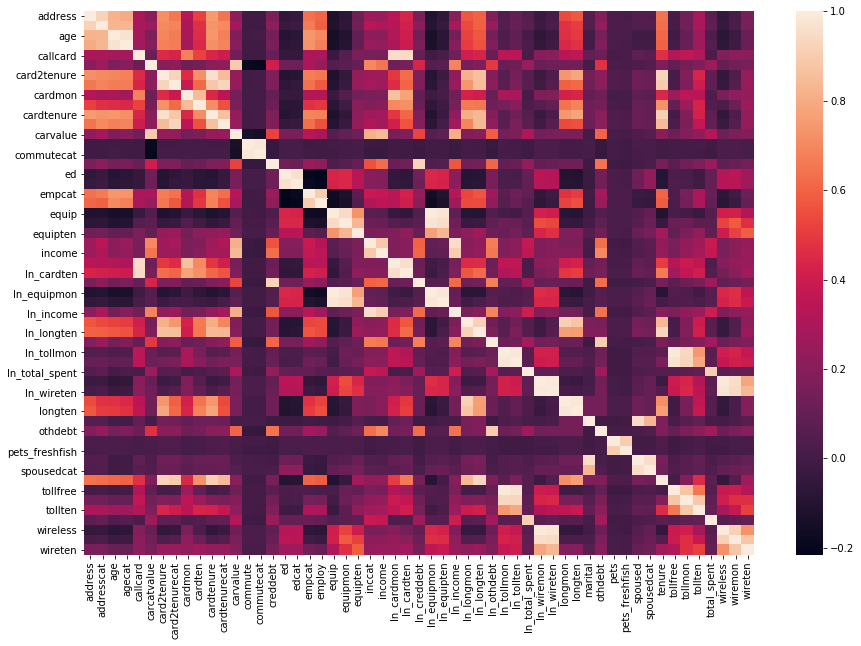

In [47]:
plt.figure(figsize = (15,10))
sns.heatmap(data[high_corr].corr())
plt.show()

In [48]:
# categorical and continuous columns in highly correlated columns
nominal, ordinal, continuous = [],[],[]
for i in high_corr:
    if i in all_cat_nominal:
        nominal.append(i)
    elif i in all_cat_ordinal:
        ordinal.append(i)
    else:
        continuous.append(i)
print('nominal: ', nominal)
print('ordinal: ', ordinal)
print('continuous: ', continuous)

nominal:  ['address', 'callcard', 'commute', 'commutecat', 'equip', 'marital', 'tollfree', 'wireless']
ordinal:  ['addresscat', 'agecat', 'carcatvalue', 'card2tenure', 'card2tenurecat', 'cardtenure', 'cardtenurecat', 'edcat', 'empcat', 'employ', 'inccat', 'spousedcat']
continuous:  ['age', 'cardmon', 'cardten', 'carvalue', 'creddebt', 'ed', 'equipmon', 'equipten', 'income', 'ln_cardmon', 'ln_cardten', 'ln_creddebt', 'ln_equipmon', 'ln_equipten', 'ln_income', 'ln_longmon', 'ln_longten', 'ln_othdebt', 'ln_tollmon', 'ln_tollten', 'ln_total_spent', 'ln_wiremon', 'ln_wireten', 'longmon', 'longten', 'othdebt', 'pets', 'pets_freshfish', 'spoused', 'tenure', 'tollmon', 'tollten', 'total_spent', 'wiremon', 'wireten']


In [49]:
# Removing categorical variables having numerical variables
# also removing (address,employ,cardtenure,card2tenure) these 4 columns(features) have more than 20 catagories.

drop = ['address', 'commute', 'equip', 'marital', 'tollfree', 'wireless', 'employ', 'cardtenure', 'card2tenure']

In [50]:
data.drop(drop, axis=1, inplace=True)

In [51]:
print(transform)

['longmon', 'longten', 'tollten', 'tollmon', 'wiremon', 'wireten', 'equipmon', 'equipten', 'cardmon', 'cardten', 'income', 'creddebt', 'othdebt']


In [52]:
# deleting redundant variables, as log transformation is already present    
data.drop(transform, axis=1, inplace=True)

In [53]:
data.shape

(5000, 106)

### Dummy creation for categorical data

**Separating nominal and ordinal variables**

In [54]:
# Updating catagorical variables.
cat_var = list(set(data.columns).intersection(all_cat_var))
cat_ordinal = list(set(data[cat_var].columns).intersection(all_cat_ordinal))
cat_ordinal.sort()
cat_nominal = list(set(data[cat_var].columns).intersection(all_cat_nominal))
cat_nominal.sort()

In [55]:
print('catagorical ordinal features : ')
print(cat_ordinal)
print(' ')
print('catagorical nominal features : ')
print(cat_nominal)

catagorical ordinal features : 
['addresscat', 'agecat', 'carcatvalue', 'card2tenurecat', 'cardtenurecat', 'cars', 'edcat', 'empcat', 'inccat', 'jobsat', 'spousedcat', 'townsize']
 
catagorical nominal features : 
['active', 'bfast', 'callcard', 'callid', 'callwait', 'carbought', 'carbuy', 'card', 'card2', 'card2benefit', 'card2fee', 'card2type', 'cardbenefit', 'cardfee', 'cardtype', 'carown', 'cartype', 'churn', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat', 'commutemotorcycle', 'commutenonmotor', 'commutepublic', 'commuterail', 'commutewalk', 'confer', 'default', 'ebill', 'forward', 'gender', 'homeown', 'hometype', 'internet', 'jobcat', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 'polcontrib', 'polparty', 'polview', 'reason', 'region', 'response_01', 'response_02', 'response_03', 'retire', 'telecommute', 'union', 'voice', 'vote']


In [56]:
# Get the dummies for nominal variables, other than binomial
cat_dummy = []
print('dummies variables with uniques')
for i in cat_nominal:
    if (data[i].nunique() > 2):
        cat_dummy.append(i)
        print(i, '\t', data[i].nunique())

dummies variables with uniques
bfast 	 3
card 	 5
card2 	 5
card2benefit 	 4
card2type 	 4
cardbenefit 	 4
cardtype 	 4
commutecat 	 5
hometype 	 4
internet 	 5
jobcat 	 6
polview 	 7
reason 	 5
region 	 5


In [57]:
# Creating Dummy Variables for categorical variables
for col in cat_dummy:
    data = dummy(data, col)

In [58]:
data.shape

(5000, 144)

In [59]:
data.head(2)

,townsize,gender,age,agecat,ed,edcat,union,empcat,retire,inccat,...,polview_6,polview_7,reason_1,reason_2,reason_3,reason_4,region_2,region_3,region_4,region_5
0,4.0,1,20,2,15,3,1,1,0,2,...,1,0,0,0,0,0,0,0,0,0
1,1.0,0,22,2,17,4,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 144 entries, townsize to region_5
dtypes: float64(19), int64(73), uint8(52)
memory usage: 3.8 MB


## Data Preparation (Feature Engineering – Feature Reduction)

**To check co-relation of Y & X(numerical features) and selecting the top features which are highly correlated to Y variable**

In [61]:
column_names = pd.Series(list(data.corrwith(data.ln_total_spent).index), name='Column_Names')
r_values =  pd.Series(list(data.corrwith(data.ln_total_spent)), name='r_values')
corr = pd.concat([column_names, r_values], axis=1)
corr['r_values_abs'] = np.abs(corr.r_values)
corr = corr.sort_values(by=['r_values_abs'], ascending=False)
corr.head()

,Column_Names,r_values,r_values_abs
78,ln_total_spent,1.000000,1.000000
77,total_spent,0.909426,0.909426
89,ln_income,0.404441,0.404441
9,inccat,0.381432,0.381432
29,carvalue,0.308661,0.308661


In [62]:
# Selecting top  features having co-relation greater than 0.2 
corr_cols = list(set(corr[corr.r_values_abs >= 0.2]['Column_Names']).difference(['ln_total_spent','total_spent']))
print(corr_cols)

['carvalue', 'inccat', 'ln_othdebt', 'ln_income', 'ln_creddebt', 'carcatvalue']


### Feature Engineering

In [63]:
# Separating features (X-variables) & Y(dependent) variable into 2 separate dataframe
features = data[data.columns.difference(['ln_total_spent', 'total_spent'])]
target = data['ln_total_spent']

#### Feature Selection based on Importance using F - Regression

In [64]:
from sklearn.feature_selection import f_regression

# Performing f-test for each x variable with y
f_values, p_values = f_regression(features, target)

# Storing data as a DataFrame
fr_df = pd.DataFrame({'Features':features.columns, 'F_values':f_values, 'p_values':p_values.round(3)})

# Getting significant variables at 90% : p = 0.10
fr_df = fr_df.loc[fr_df.p_values <= 0.1].reset_index(drop = True)

f_cols = list(fr_df.Features)
print(f_cols)

['addresscat', 'agecat', 'bfast_2', 'bfast_3', 'callid', 'callwait', 'carcatvalue', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2tenurecat', 'card_2', 'card_3', 'card_4', 'card_5', 'cardtenurecat', 'carown', 'carvalue', 'commutebike', 'confer', 'ebill', 'ed', 'edcat', 'empcat', 'forward', 'gender', 'homeown', 'hometype_2', 'hometype_3', 'hourstv', 'inccat', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobsat', 'ln_cardten', 'ln_creddebt', 'ln_equipmon', 'ln_equipten', 'ln_income', 'ln_longmon', 'ln_longten', 'ln_othdebt', 'ln_tollmon', 'ln_tollten', 'ln_wiremon', 'ln_wireten', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 'polcontrib', 'polview_4', 'polview_6', 'reason_1', 'reason_2', 'reason_3', 'reason_4', 'region_5', 'response_02', 'response_03', 'retire', 'spoused', 'spousedcat', 'tenure', 'voice', 'vote']


### Recursive Feature Elimination

In [65]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Using LinearRegressor as an estimator
rf_est = LinearRegression()

# Using RFE to get importance of each variable
rfe = RFE(estimator = rf_est)
rfe.fit(features, target)

# Getting important features
rfe_cols = list(features.columns[rfe.support_])
print(rfe_cols)

['bfast_2', 'callcard', 'carbuy', 'carcatvalue', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2fee', 'card_2', 'card_3', 'card_4', 'card_5', 'cardfee', 'cardtenurecat', 'cardtype_2', 'cartype', 'churn', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat_4', 'commutecat_5', 'commutenonmotor', 'commuterail', 'default', 'ebill', 'edcat', 'forward', 'gender', 'hometype_3', 'inccat', 'internet_1', 'internet_3', 'internet_4', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'ln_cardmon', 'ln_income', 'ln_longten', 'ln_wiremon', 'ln_wireten', 'owndvd', 'ownfax', 'ownpc', 'owntv', 'ownvcr', 'pager', 'pets_birds', 'pets_reptiles', 'pets_saltfish', 'polview_3', 'polview_4', 'polview_5', 'polview_6', 'polview_7', 'reason_1', 'reason_2', 'reason_3', 'reason_4', 'region_2', 'region_4', 'region_5', 'response_02', 'response_03', 'telecommute', 'union', 'voice']


###  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [66]:
# combining all important variables
combine_feature = f_cols + rfe_cols
combine_feature = list(set(combine_feature))
combine_feature.sort()
print('no. of combine features: ', len(combine_feature))
print(combine_feature)

no. of combine features:  108
['addresscat', 'agecat', 'bfast_2', 'bfast_3', 'callcard', 'callid', 'callwait', 'carbuy', 'carcatvalue', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2fee', 'card2tenurecat', 'card_2', 'card_3', 'card_4', 'card_5', 'cardfee', 'cardtenurecat', 'cardtype_2', 'carown', 'cartype', 'carvalue', 'churn', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat_4', 'commutecat_5', 'commutenonmotor', 'commuterail', 'confer', 'default', 'ebill', 'ed', 'edcat', 'empcat', 'forward', 'gender', 'homeown', 'hometype_2', 'hometype_3', 'hourstv', 'inccat', 'internet_1', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'jobsat', 'ln_cardmon', 'ln_cardten', 'ln_creddebt', 'ln_equipmon', 'ln_equipten', 'ln_income', 'ln_longmon', 'ln_longten', 'ln_othdebt', 'ln_tollmon', 'ln_tollten', 'ln_wiremon', 'ln_wireten', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda',

In [67]:
# High VIF means information in that variable has already been explained by other X variables present in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

model_param = 'ln_total_spent ~ ' + ' + '.join(combine_feature)
print(model_param)

ln_total_spent ~ addresscat + agecat + bfast_2 + bfast_3 + callcard + callid + callwait + carbuy + carcatvalue + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2fee + card2tenurecat + card_2 + card_3 + card_4 + card_5 + cardfee + cardtenurecat + cardtype_2 + carown + cartype + carvalue + churn + commutebike + commutebus + commutecar + commutecarpool + commutecat_4 + commutecat_5 + commutenonmotor + commuterail + confer + default + ebill + ed + edcat + empcat + forward + gender + homeown + hometype_2 + hometype_3 + hourstv + inccat + internet_1 + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat + ln_cardmon + ln_cardten + ln_creddebt + ln_equipmon + ln_equipten + ln_income + ln_longmon + ln_longten + ln_othdebt + ln_tollmon + ln_tollten + ln_wiremon + ln_wireten + multline + news + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + owntv + ownvcr + pager + pets_birds + pets_reptiles + pets_saltfish + polcontrib + polview_3

In [68]:
# First taking all the vaiables and iteratively removing variable with higher VIF we got the final eqn as new_eqn

# dropping : ln_wiremon + ln_tollmon + ln_equipmon + ln_cardten + ln_longten + ln_income + ed + spousedcat + ln_cardmon +
# card2tenurecat + carvalue + tenure + agecat + 

model_param = ''' ln_total_spent ~ addresscat + bfast_2 + bfast_3 + callcard + callid + callwait + carbuy + 
carcatvalue + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2fee + card_2 + card_3 + 
card_4 + card_5 + cardfee + cardtenurecat + cardtype_2 + carown + cartype + churn + commutebike + commutebus + 
commutecar + commutecarpool + commutecat_4 + commutecat_5 + commutenonmotor + commuterail + confer + default + ebill +
edcat + empcat + forward + gender + homeown + hometype_2 + hometype_3 + hourstv + inccat + internet_1 + internet_3 + 
internet_4 + jobcat_2 + jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat + ln_creddebt + ln_equipten + ln_longmon +  
ln_othdebt + ln_tollten + ln_wireten + multline + news + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + 
owntv + ownvcr + pager + pets_birds + pets_reptiles + pets_saltfish + polcontrib + polview_3 + polview_4 + polview_5 + 
polview_6 + polview_7 + reason_1 + reason_2 + reason_3 + reason_4 + region_2 + region_4 + region_5 + response_02 + 
response_03 + retire + spoused + telecommute + union + voice + vote '''

# separate the Y and X variables
y, X = dmatrices(model_param, data = data, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.sort_values('VIF', ascending=False, inplace=True, ignore_index=True)
vif.head()

,Features,VIF
0,Intercept,140.073426
1,empcat,4.540285
2,inccat,4.175495
3,cardtenurecat,3.295412
4,addresscat,3.088058


In [69]:
# All the features have less than 5 VIF Factor(low Multicollinearity). using these features for model building.
vif_cols = list(set(vif.Features).difference(['Intercept']))
vif_cols.sort()
print('numbers of selected features: ', len(vif_cols))
print(vif_cols)

numbers of selected features:  95
['addresscat', 'bfast_2', 'bfast_3', 'callcard', 'callid', 'callwait', 'carbuy', 'carcatvalue', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2fee', 'card_2', 'card_3', 'card_4', 'card_5', 'cardfee', 'cardtenurecat', 'cardtype_2', 'carown', 'cartype', 'churn', 'commutebike', 'commutebus', 'commutecar', 'commutecarpool', 'commutecat_4', 'commutecat_5', 'commutenonmotor', 'commuterail', 'confer', 'default', 'ebill', 'edcat', 'empcat', 'forward', 'gender', 'homeown', 'hometype_2', 'hometype_3', 'hourstv', 'inccat', 'internet_1', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'jobsat', 'ln_creddebt', 'ln_equipten', 'ln_longmon', 'ln_othdebt', 'ln_tollten', 'ln_wireten', 'multline', 'news', 'owncd', 'owndvd', 'ownfax', 'owngame', 'ownipod', 'ownpc', 'ownpda', 'owntv', 'ownvcr', 'pager', 'pets_birds', 'pets_reptiles', 'pets_saltfish', 'polcontrib', 'polview_3', 'polview_4', 'polview_5', 'polview_6

# Model Implementation

**Train And Test data**

In [70]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

# Linear Regression Model

In [71]:
# Getting model equation
formula_m0 = "ln_total_spent ~ " + " + ".join(vif_cols)
print(formula_m0)

ln_total_spent ~ addresscat + bfast_2 + bfast_3 + callcard + callid + callwait + carbuy + carcatvalue + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2fee + card_2 + card_3 + card_4 + card_5 + cardfee + cardtenurecat + cardtype_2 + carown + cartype + churn + commutebike + commutebus + commutecar + commutecarpool + commutecat_4 + commutecat_5 + commutenonmotor + commuterail + confer + default + ebill + edcat + empcat + forward + gender + homeown + hometype_2 + hometype_3 + hourstv + inccat + internet_1 + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat + ln_creddebt + ln_equipten + ln_longmon + ln_othdebt + ln_tollten + ln_wireten + multline + news + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + owntv + ownvcr + pager + pets_birds + pets_reptiles + pets_saltfish + polcontrib + polview_3 + polview_4 + polview_5 + polview_6 + polview_7 + reason_1 + reason_2 + reason_3 + reason_4 + region_2 + region_4 + region_5 + respo

#### Model - 0 

In [72]:
formula_m0 = '''ln_total_spent ~ addresscat + bfast_2 + bfast_3 + callcard + callid + callwait + carbuy + carcatvalue + 
card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2fee + card_2 + card_3 + card_4 + card_5 + cardfee + 
cardtenurecat + cardtype_2 + carown + cartype + churn + commutebike + commutebus + commutecar + commutecarpool + 
commutecat_4 + commutecat_5 + commutenonmotor + commuterail + confer + default + ebill + edcat + empcat + forward + 
gender + homeown + hometype_2 + hometype_3 + hourstv + inccat + internet_1 + internet_3 + internet_4 + jobcat_2 + 
jobcat_3 + jobcat_4 + jobcat_5 + jobcat_6 + jobsat + ln_creddebt + ln_equipten + ln_longmon + ln_othdebt + ln_tollten + 
ln_wireten + multline + news + owncd + owndvd + ownfax + owngame + ownipod + ownpc + ownpda + owntv + ownvcr + pager + 
pets_birds + pets_reptiles + pets_saltfish + polcontrib + polview_3 + polview_4 + polview_5 + polview_6 + polview_7 + 
reason_1 + reason_2 + reason_3 + reason_4 + region_2 + region_4 + region_5 + response_02 + response_03 + retire + 
spoused + telecommute + union + voice + vote'''

model0 = smf.ols(formula = formula_m0, data = train).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spent   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     19.69
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          2.21e-253
Time:                        11:38:24   Log-Likelihood:                -2670.4
No. Observations:                3500   AIC:                             5533.
Df Residuals:                    3404   BIC:                             6124.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.3622      0.104     

### Nelglecting the features which have p values > 0.05

## Model-1

**Removing insignificant variables based on p-value > 0.05 from model summary:**
    '''ln_othdebt, homeown, callid, card2fee, ownpda, jobcat_2, callwait, confer, jobsat, multline, cardtenurecat, commutecar, 
    ln_tollten, ownpc, polcontrib, jobcat_3, carcatvalue, hourstv, news, commutebus, owntv, ln_wireten, region_2, carbuy, 
    hometype_2, bfast_3, cardtype_2, response_02, commutecat_4, forward, voice, cardfee, internet_1, vote, callcard, 
    ln_creddebt, ln_longmon, pets_reptiles, commuterail, churn, owngame, commutecarpool, commutebike, carown, ownfax, 
    telecommute, ebill, spoused, hometype_3, pets_birds, owndvd, addresscat, region_4, pager, response_03, union, 
    pets_saltfish, polview_6, jobcat_4, jobcat_5, ownipod, jobcat_6, edcat, reason_3, commutenonmotor, region_5, commutecat_5, 
    polview_3, polview_4, polview_5, default, owncd, ln_equipten, internet_4, internet_3, cartype, bfast_2, empcat'''

In [73]:
formula_m1 = '''ln_total_spent ~ card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card_2 + card_3 + card_4 + card_5 + 
gender + inccat + ownvcr + polview_7 + reason_1 + reason_2 + reason_4 + retire'''

model1 = smf.ols(formula = formula_m1, data = train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spent   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     106.0
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          1.72e-299
Time:                        11:38:24   Log-Likelihood:                -2706.7
No. Observations:                3500   AIC:                             5449.
Df Residuals:                    3482   BIC:                             5560.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.3987      0.048    132.

### POST MODELING
### Model Validation
### Predicting the Y on the train and test dataset

In [74]:
# Transforming log values into actual values in both training and testing data sets
train.loc[:,'lr_pred'] = np.exp(model1.predict(train))
test.loc[:,'lr_pred'] = np.exp(model1.predict(test))

In [75]:
lr_r2 = metrics.r2_score(train.total_spent, train.lr_pred)
print('R-square Score:', lr_r2)

R-square Score: 0.31536160797410895


In [76]:
train[['total_spent','lr_pred']].head()

,total_spent,lr_pred
1840,313.34,370.550872
2115,764.01,497.588018
4437,443.09,272.112279
1146,172.83,326.793139
2486,220.63,326.793139


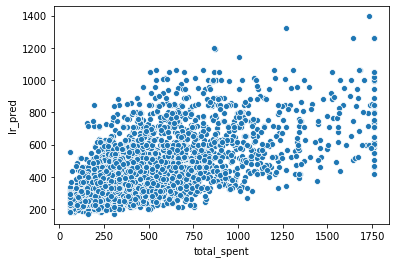

In [77]:
sns.scatterplot(train.total_spent, train.lr_pred)
plt.show()

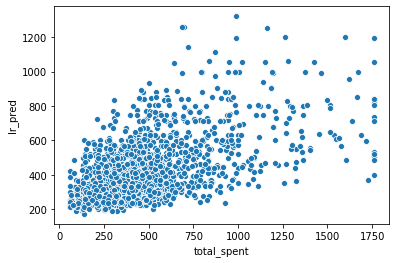

In [78]:
sns.scatterplot(test.total_spent, test.lr_pred)
plt.show()

**Checking Metrics for both training and testing data sets**

In [79]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
lr_MAPE_train = np.mean(np.abs(train.total_spent - train.lr_pred)/train.total_spent)
print(lr_MAPE_train)
lr_MAPE_test = np.mean(np.abs(test.total_spent - test.lr_pred)/test.total_spent)
print(lr_MAPE_test)

# Root Mean Squared error
print("\n RMSE values for training and testing data :")
lr_RMSE_train = np.sqrt(mean_squared_error(train.total_spent,train.lr_pred))
print(lr_RMSE_train)
lr_RMSE_test =np.sqrt(mean_squared_error(test.total_spent,test.lr_pred))
print(lr_RMSE_test)

MAPE values for training and testing data :
0.47276673800034186
0.4811486237443822

 RMSE values for training and testing data :
268.04047452656346
271.31271416152276


**Analysis of Residuals**

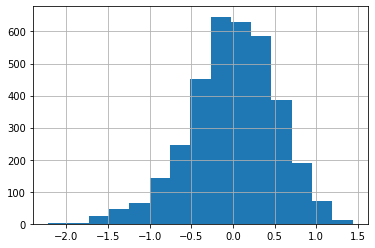

In [80]:
# Checking Errors distribution
model1.resid.hist(bins=15)
plt.show()
# Residuals following Normal distribution. This is one of the Assumption in Linear Regression.

In [81]:
# assumption: mean of residuals/errors is zero
print(model1.resid.mean())

2.9643335405385837e-14


In [82]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(model1.resid, train.total_spent))

(0.7010952758018842, 0.0)


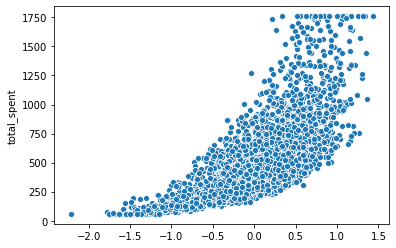

In [83]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(model1.resid, train.total_spent)
plt.show()

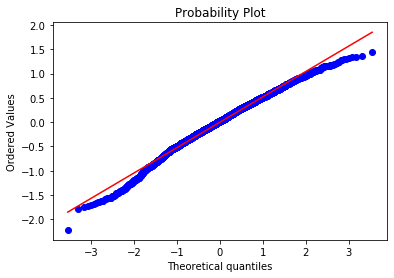

In [84]:
# Q-Q plot of Residuals
stats.probplot(model1.resid, dist='norm', plot=pylab)
pylab.show()

**Decile Analysis**

***Decile analysis for validation of models - Business validation***

In [85]:
# Writing output data into excel
output = pd.ExcelWriter('CreditCardSpend_output.xlsx')

In [86]:
# create the 10 groups in the data
train.loc[:,'lr_deciles'] = pd.qcut(train['lr_pred'], 10, labels = False)
test.loc[:,'lr_deciles'] = pd.qcut(test['lr_pred'], 10, labels = False)

# Decile Analysis for train_output data
lr_decile_train = train.groupby('lr_deciles')[['total_spent', 'lr_pred']].mean().reset_index().sort_values(
    by = 'lr_deciles', ascending = False)

# Decile Analysis for test_output data
lr_decile_test = test.groupby('lr_deciles')[['total_spent', 'lr_pred']].mean().reset_index().sort_values(
    by = 'lr_deciles', ascending = False)

# write the data into the file
lr_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=0, index = False)
lr_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=5, index = False)

In [87]:
lr_decile_train

,lr_deciles,total_spent,lr_pred
9,9,906.654552,835.718745
8,8,705.088458,621.999365
7,7,598.160121,527.159569
6,6,522.795772,462.122993
5,5,481.622043,412.057069
4,4,411.962308,366.113110
3,3,389.554686,331.903977
2,2,331.449085,305.053284
1,1,321.224482,273.716075
0,0,268.334264,229.368950


In [88]:
lr_decile_test

,lr_deciles,total_spent,lr_pred
9,9,885.005383,846.471084
8,8,691.918286,615.855668
7,7,577.859648,527.984388
6,6,552.387456,460.867523
5,5,464.627666,411.161323
4,4,447.666918,364.253749
3,3,381.853975,330.903114
2,2,358.770719,304.437791
1,1,334.629257,272.703885
0,0,270.374210,231.277206


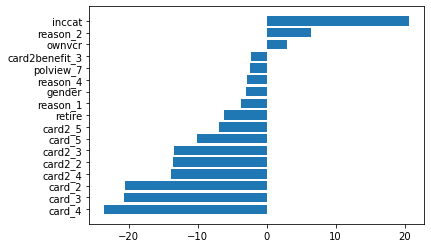

In [89]:
# Getting importance of factors
lr_fi = pd.DataFrame({'Features' : model1.tvalues[1:].index,
                      'T_value' : model1.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)

lr_fi.to_excel(output, 'Drivers', startrow=2 , startcol=0, index = False)

plt.barh(width = lr_fi.T_value, y = lr_fi.Features)
plt.show()

# Machine learning

In [90]:
# Getting final features
X_cols = list(model1.pvalues.index.difference(['Intercept']))
print(X_cols)
X = data[X_cols]
Y = data.ln_total_spent

['card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card_2', 'card_3', 'card_4', 'card_5', 'gender', 'inccat', 'ownvcr', 'polview_7', 'reason_1', 'reason_2', 'reason_4', 'retire']


#### Getting Train and Test dataset for Machine Learning modelling

In [91]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [92]:
# dataframe for train and test output
train_output = pd.DataFrame()
test_output = pd.DataFrame()

# Including the Y(dependent) Variable to compare
train_output['total_spent'] = np.exp(train_y)
test_output['total_spent'] = np.exp(test_y)

In [93]:
# Importing packages
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.tree import export_graphviz, export
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge,Lasso

## Decision Trees 

In [94]:
# Importing packages
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export
from sklearn.model_selection import GridSearchCV

In [95]:
# Model building
param = {'max_depth': range(5,15),
         'min_samples_split' : range(2,5),
         'min_samples_leaf' : range(5,10)
         }

gscv_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                        param_grid = param, 
                        cv = 10,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=5).fit(train_x, train_y)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.0min finished


In [96]:
gscv_dt.best_params_

{'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [97]:
# best Score
-1*gscv_dt.best_score_

0.3129891311703043

In [98]:
-1*gscv_dt.score(train_x, train_y)

0.2642909587691854

**Building final descision  tree model on best parameters**

In [99]:
dt = gscv_dt.best_estimator_

# Predicting values for both training and testing data sets
train_output.loc[:, 'dt_pred'] = np.exp(dt.predict(train_x))
test_output.loc[:, 'dt_pred'] = np.exp(dt.predict(test_x))

dt_r2 = metrics.r2_score(train_output.total_spent, train_output.dt_pred)
print('R-square Score:', dt_r2)

R-square Score: 0.33810143188318864


In [100]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
dt_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.dt_pred)/train_output.total_spent)
print(dt_MAPE_train)
dt_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.dt_pred)/test_output.total_spent)
print(dt_MAPE_test)

# Root Mean Squared error
print("\nRMSE values for training and testing data :")
dt_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.dt_pred))
print(dt_RMSE_train)
dt_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.dt_pred))
print(dt_RMSE_test)

MAPE values for training and testing data :
0.4600283531804034
0.5075432916486162

RMSE values for training and testing data :
263.55148907742046
276.4604013885058


**Decile Analysis**

In [101]:
# Creating Deciles
train_output.loc[:,'dt_deciles'] = pd.qcut(train_output['dt_pred'], 10, labels = False)
test_output.loc[:,'dt_deciles'] = pd.qcut(test_output['dt_pred'], 10, labels = False)

# Decile Analysis for train_output data
dt_decile_train = train_output.groupby('dt_deciles')[['total_spent', 'dt_pred']].mean().reset_index().sort_values(
    by = 'dt_deciles', ascending = False)

# Decile Analysis for test_output data
dt_decile_test = test_output.groupby('dt_deciles')[['total_spent', 'dt_pred']].mean().reset_index().sort_values(
    by = 'dt_deciles', ascending = False)

# write the data into the file
dt_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=10, index = False)
dt_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=15, index = False)

In [102]:
dt_decile_train

,dt_deciles,total_spent,dt_pred
9,9,926.611007,839.599398
8,8,706.244627,631.304844
7,7,597.979291,533.813721
6,6,532.792264,464.111969
5,5,468.981755,414.931204
4,4,423.644005,378.633257
3,3,385.080793,342.167793
2,2,343.207162,307.287222
1,1,317.265040,273.419903
0,0,255.083444,215.715610


In [103]:
dt_decile_test

,dt_deciles,total_spent,dt_pred
9,9,873.298416,862.602985
8,8,684.242612,628.911691
7,7,578.742342,526.634015
6,6,512.110075,457.258862
5,5,498.223812,412.106386
4,4,384.697852,375.514428
3,3,402.028955,342.262508
2,2,367.369152,310.088159
1,1,354.861307,278.610436
0,0,302.600533,223.274594


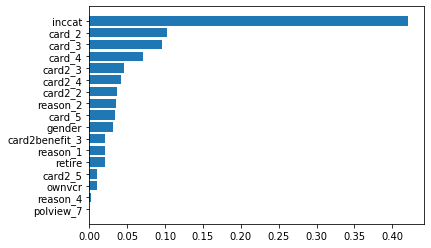

In [104]:
# Feature Impotance
dt_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : dt.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

dt_fi.to_excel(output, 'Drivers', startrow=2, startcol=5, index = False)

plt.barh(width = dt_fi.Importance, y = dt_fi.Features)
plt.show()

# Ensemble Learning

# Random Forest

In [105]:
# Importing required packages
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [106]:
param = {'n_estimators': [500,600,700],
         'max_depth': [5,6,7,8],
         'min_samples_split' : [7,8,9,10]
        }

gscv_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                       param_grid=param, 
                       cv=5, 
                       scoring = 'neg_mean_squared_error',
                       n_jobs=-1, 
                       verbose=5).fit(train_x,train_y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.7min finished


In [107]:
gscv_rf.best_params_

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 600}

In [108]:
-1*gscv_rf.best_score_

0.29814828142682104

In [109]:
-1*gscv_rf.score(train_x,train_y)

0.26461371628468217

**Building random forest on best parameters**

In [110]:
# Using best fit parameters to fit the model
rf = gscv_rf.best_estimator_

# Predicting total spent on train and test dataset
train_output.loc[:, 'rf_pred'] = np.exp(rf.predict(train_x))
test_output.loc[:, 'rf_pred'] = np.exp(rf.predict(test_x))

# R-square Score
rf_r2 = metrics.r2_score(train_output.total_spent, train_output.rf_pred)
print('R-square Score:', rf_r2)

R-square Score: 0.3239715630599779


In [111]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
rf_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.rf_pred)/train_output.total_spent)
print(rf_MAPE_train)
rf_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.rf_pred)/test_output.total_spent)
print(rf_MAPE_test)

# Root Mean Squared error
print("\nRMSE values for training and testing data :")
rf_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.rf_pred))
print(rf_RMSE_train)
rf_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.rf_pred))
print(rf_RMSE_test)

MAPE values for training and testing data :
0.45971429694001165
0.4924108018264277

RMSE values for training and testing data :
266.3497147130627
276.45942245247784


In [112]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_output.total_spent, train_output.rf_pred)
Corr_test = stats.stats.pearsonr(test_output.total_spent, test_output.rf_pred)

print('Correlation - Train Data: ', Corr_train, ' | ', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6104304192044812, 0.0)  |  Test Data:  (0.5426304434886585, 1.3404510673389547e-115)


**Decile Analysis**

In [113]:
# Creating Deciles
train_output.loc[:,'rf_deciles'] = pd.qcut(train_output['rf_pred'], 10, labels = False)
test_output.loc[:,'rf_deciles'] = pd.qcut(test_output['rf_pred'], 10, labels = False)

# Decile Analysis for train_output data
rf_decile_train = train_output.groupby('rf_deciles')[['total_spent', 'rf_pred']].mean().reset_index().sort_values(
    by = 'rf_deciles', ascending = False)

# Decile Analysis for test_output data
rf_decile_test = test_output.groupby('rf_deciles')[['total_spent', 'rf_pred']].mean().reset_index().sort_values(
    by = 'rf_deciles', ascending = False)

# write the data into the file
rf_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=20, index = False)
rf_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=25, index = False)

In [114]:
rf_decile_train

,rf_deciles,total_spent,rf_pred
9,9,930.821061,794.714698
8,8,690.840293,598.666892
7,7,597.752147,510.510035
6,6,504.701744,436.508172
5,5,469.479267,406.926168
4,4,431.906337,378.790515
3,3,397.491376,344.771160
2,2,350.048554,316.775244
1,1,307.907201,285.335494
0,0,252.813827,238.711934


In [115]:
rf_decile_test

,rf_deciles,total_spent,rf_pred
9,9,905.194843,806.973759
8,8,645.666499,591.654329
7,7,570.063161,514.935180
6,6,572.901012,437.635659
5,5,430.527114,403.372410
4,4,451.336496,373.574667
3,3,357.627383,337.968687
2,2,379.431527,316.054477
1,1,354.609748,287.791076
0,0,285.691199,241.398668


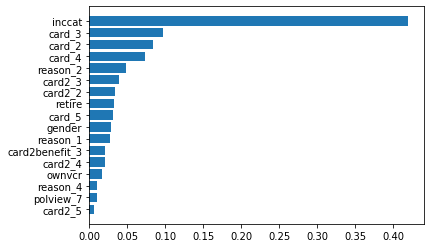

In [116]:
# Feature Impotance
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers', startrow=2, startcol=10, index = False)

plt.barh(width = rf_fi.Importance, y = rf_fi.Features)
plt.show()

# Gradient Boost Model

In [117]:
# Getting parameters for best fit using GridSeachCV
param = {'max_depth' : range(2,6),
         'min_samples_split' : range(2,5),
         'min_samples_leaf' : range(10,15)
        }

gscv_gb = GridSearchCV(estimator = GradientBoostingRegressor(random_state = 42), 
                       param_grid = param,
                       cv = 5,
                       scoring = 'neg_mean_squared_error',
                       n_jobs = -1,
                       verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


In [118]:
gscv_gb.best_params_

{'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split': 2}

In [119]:
-1*gscv_gb.best_score_

0.28532504900368005

In [120]:
-1*gscv_gb.score(train_x, train_y)

0.26977981599486145

**Building random forest on best parameters**

In [121]:
# Using best fit parameters to fit the model
gb = gscv_gb.best_estimator_

# Predicting total spent on train and test dataset
train_output.loc[:, 'gb_pred'] = np.exp(gb.predict(train_x))
test_output.loc[:, 'gb_pred'] = np.exp(gb.predict(test_x))

# R-square Score
gb_r2 = metrics.r2_score(train_output.total_spent, train_output.gb_pred)
print('R-square Score:', gb_r2)

R-square Score: 0.3086905886024519


In [122]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
gb_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.gb_pred)/train_output.total_spent)
print(gb_MAPE_train)
gb_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.gb_pred)/test_output.total_spent)
print(gb_MAPE_test)

# Root Mean Squared error
print("\nRMSE values for training and testing data :")
gb_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.gb_pred))
print(gb_RMSE_train)
gb_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.gb_pred))
print(gb_RMSE_test)

MAPE values for training and testing data :
0.46665043578322146
0.4850183143583451

RMSE values for training and testing data :
269.3431830470306
274.03636720063963


In [123]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_output.total_spent, train_output.gb_pred)
Corr_test = stats.stats.pearsonr(test_output.total_spent, test_output.gb_pred)

print('Correlation - Train Data: ', Corr_train, ' | ', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5973916600342145, 0.0)  |  Test Data:  (0.556958187323747, 5.890804596123279e-123)


**Decile Analysis**

In [124]:
# Creating Deciles
train_output.loc[:,'gb_deciles'] = pd.qcut(train_output['gb_pred'], 10, labels = False)
test_output.loc[:,'gb_deciles'] = pd.qcut(test_output['gb_pred'], 10, labels = False)

# Decile Analysis for train_output data
gb_decile_train = train_output.groupby('gb_deciles')[['total_spent', 'gb_pred']].mean().reset_index().sort_values(
    by = 'gb_deciles', ascending = False)

# Decile Analysis for test_output data
gb_decile_test = test_output.groupby('gb_deciles')[['total_spent', 'gb_pred']].mean().reset_index().sort_values(
    by = 'gb_deciles', ascending = False)

# write the data into the file
gb_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=30, index = False)
gb_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=35, index = False)

In [125]:
gb_decile_train

,gb_deciles,total_spent,gb_pred
9,9,910.857775,790.069881
8,8,692.522413,581.869547
7,7,607.082503,508.703292
6,6,526.522754,448.731955
5,5,469.419921,407.925535
4,4,437.090256,378.914715
3,3,382.605325,346.528325
2,2,330.367928,317.423128
1,1,324.089537,285.462908
0,0,252.202315,237.283975


In [126]:
gb_decile_test

,gb_deciles,total_spent,gb_pred
9,9,894.239516,801.069844
8,8,676.593311,575.374359
7,7,578.669012,508.981633
6,6,526.206005,448.532872
5,5,467.121837,406.389722
4,4,436.018307,375.980718
3,3,393.641233,340.784170
2,2,370.062467,314.015661
1,1,335.185333,287.851599
0,0,273.831866,240.033562


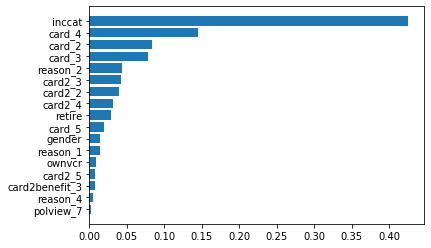

In [127]:
# Feature Impotance
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gb.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

gb_fi.to_excel(output, 'Drivers', startrow=2, startcol=15, index = False)

plt.barh(width = gb_fi.Importance, y = gb_fi.Features)
plt.show()

# XGBOOST

In [128]:
# Importing Required packages
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

In [129]:
param = {'n_estimators': [100,150,200],
        'max_depth':[2,3,4,5]}

gscv_xgb = GridSearchCV(estimator=XGBRegressor(), 
                        param_grid=param,
                        cv=5,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1, verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


In [130]:
gscv_xgb.best_params_

{'max_depth': 2, 'n_estimators': 100}

In [131]:
-1*gscv_xgb.best_score_

0.2816930132096365

In [132]:
-1*gscv_xgb.score(train_x, train_y)

0.2696729254694102

**Building XGBOOST on best parameters**

In [133]:
# Using best fit parameters to fit the model
xgb = gscv_xgb.best_estimator_

# Predicting total spent on train and test dataset
train_output.loc[:, 'xgb_pred'] = np.exp(xgb.predict(train_x))
test_output.loc[:, 'xgb_pred'] = np.exp(xgb.predict(test_x))

# R-square Score
xgb_r2 = metrics.r2_score(train_output.total_spent, train_output.xgb_pred)
print('R-square Score:', xgb_r2)

R-square Score: 0.31813698366207677


In [134]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
xgb_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.xgb_pred)/train_output.total_spent)
print(xgb_MAPE_train)
xgb_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.xgb_pred)/test_output.total_spent)
print(xgb_MAPE_test)

# Root Mean Squared error
print("\nRMSE values for training and testing data :")
xgb_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.xgb_pred))
print(xgb_RMSE_train)
xgb_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.xgb_pred))
print(xgb_RMSE_test)

MAPE values for training and testing data :
0.46748097332634914
0.4854053620997487

RMSE values for training and testing data :
267.49663381175674
273.1102943816523


In [135]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_output.total_spent, train_output.xgb_pred)
Corr_test = stats.stats.pearsonr(test_output.total_spent, test_output.xgb_pred)

print('Correlation - Train Data: ', Corr_train, ' | ', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.59777320264829, 0.0)  |  Test Data:  (0.5563447313509524, 1.2375282857915755e-122)


**Decile Analysis**

In [136]:
# Creating Deciles
train_output.loc[:,'xgb_deciles'] = pd.qcut(train_output['xgb_pred'], 10, labels = False)
test_output.loc[:,'xgb_deciles'] = pd.qcut(test_output['xgb_pred'], 10, labels = False)

# Decile Analysis for train_output data
xgb_decile_train = train_output.groupby('xgb_deciles')[['total_spent', 'xgb_pred']].mean().reset_index().sort_values(
    by = 'xgb_deciles', ascending = False)

# Decile Analysis for test_output data
xgb_decile_test = test_output.groupby('xgb_deciles')[['total_spent', 'xgb_pred']].mean().reset_index().sort_values(
    by = 'xgb_deciles', ascending = False)

# write the data into the file
xgb_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=40, index = False)
xgb_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=45, index = False)

In [137]:
xgb_decile_train

,xgb_deciles,total_spent,xgb_pred
9,9,911.876775,809.778748
8,8,705.546305,604.466431
7,7,583.349676,519.825623
6,6,547.899217,459.377655
5,5,468.445888,412.063263
4,4,425.952571,375.401276
3,3,386.023977,338.661774
2,2,329.624843,312.119629
1,1,314.329523,275.549652
0,0,260.799998,229.683365


In [138]:
xgb_decile_test

,xgb_deciles,total_spent,xgb_pred
9,9,894.008716,821.662598
8,8,683.341206,595.646484
7,7,573.066346,517.055054
6,6,526.094877,457.927490
5,5,474.756118,410.919250
4,4,434.360539,370.662964
3,3,390.803400,334.216827
2,2,343.915600,308.506348
1,1,354.436400,277.547333
0,0,274.214199,232.842163


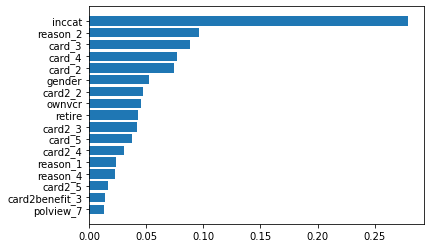

In [139]:
# Feature Impotance
xgb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : xgb.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

xgb_fi.to_excel(output, 'Drivers', startrow=2, startcol=20, index = False)

plt.barh(width = xgb_fi.Importance, y = xgb_fi.Features)
plt.show()

**Plotting the feature importances**

<Figure size 864x432 with 0 Axes>

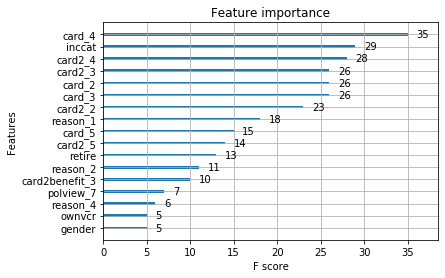

In [140]:
from xgboost import plot_importance
plt.figure(figsize = (12,6))
plot_importance(xgb)
plt.show()

## SVM(Support Vector Machine)


In [141]:
# Importing required modules
from sklearn.svm import SVR
from sklearn.svm import LinearSVR 

In [142]:
# Model building using Linear svm 
#'C': [1,0.1,0.001,10,100]
#'gamma':[0.0001, 0.001, 0.01, 0.1]
param = {'kernel': ['linear','rbf','poly'],
        'gamma':['auto']}

gscv_svr = GridSearchCV(SVR(),
                       param,
                       cv=5,
                       scoring = 'neg_mean_squared_error',
                       verbose=5,
                       n_jobs=-1).fit(train_x,train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   16.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.1s finished


In [143]:
gscv_svr.best_params_

{'gamma': 'auto', 'kernel': 'linear'}

In [144]:
-1*gscv_svr.best_score_

0.280090152549747

In [145]:
-1*gscv_svr.score(train_x, train_y)

0.27682986629887535

**Building svrOOST on best parameters**

In [146]:
# Using best fit parameters to fit the model
svr = gscv_svr.best_estimator_

# Predicting total spent on train and test dataset
train_output.loc[:, 'svr_pred'] = np.exp(svr.predict(train_x))
test_output.loc[:, 'svr_pred'] = np.exp(svr.predict(test_x))

# R-square Score
svr_r2 = metrics.r2_score(train_output.total_spent, train_output.svr_pred)
print('R-square Score:', svr_r2)

R-square Score: 0.3149342699295582


In [147]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
svr_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.svr_pred)/train_output.total_spent)
print(svr_MAPE_train)
svr_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.svr_pred)/test_output.total_spent)
print(svr_MAPE_test)

# Root Mean Squared error
print("\nRMSE values for training and testing data :")
svr_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.svr_pred))
print(svr_RMSE_train)
svr_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.svr_pred))
print(svr_RMSE_test)

MAPE values for training and testing data :
0.48431806133202704
0.49051012941575156

RMSE values for training and testing data :
268.1241143165953
270.47398216773973


In [148]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_output.total_spent, train_output.svr_pred)
Corr_test = stats.stats.pearsonr(test_output.total_spent, test_output.svr_pred)

print('Correlation - Train Data: ', Corr_train, ' | ', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5893943118069167, 0.0)  |  Test Data:  (0.562838626923441, 4.420670795862529e-126)


**Decile Analysis**

In [149]:
# Creating Deciles
train_output.loc[:,'svr_deciles'] = pd.qcut(train_output['svr_pred'], 10, labels = False)
test_output.loc[:,'svr_deciles'] = pd.qcut(test_output['svr_pred'], 10, labels = False)

# Decile Analysis for train_output data
svr_decile_train = train_output.groupby('svr_deciles')[['total_spent', 'svr_pred']].mean().reset_index().sort_values(
    by = 'svr_deciles', ascending = False)

# Decile Analysis for test_output data
svr_decile_test = test_output.groupby('svr_deciles')[['total_spent', 'svr_pred']].mean().reset_index().sort_values(
    by = 'svr_deciles', ascending = False)

# write the data into the file
svr_decile_train.to_excel(output, 'Decile', startrow=2 , startcol=50, index = False)
svr_decile_test.to_excel(output, 'Decile', startrow=2 , startcol=55, index = False)

In [150]:
svr_decile_train

,svr_deciles,total_spent,svr_pred
9,9,900.554855,804.725001
8,8,697.147164,609.386673
7,7,598.360296,525.825677
6,6,535.371860,469.177362
5,5,477.405504,422.342381
4,4,408.747642,377.494420
3,3,398.090980,344.736631
2,2,329.997405,318.661960
1,1,315.623988,289.394375
0,0,269.777598,247.040667


In [151]:
svr_decile_test

,svr_deciles,total_spent,svr_pred
9,9,884.154870,819.262244
8,8,702.441031,606.864243
7,7,578.960567,526.270393
6,6,531.505590,467.672586
5,5,480.852206,419.177428
4,4,445.271000,372.565892
3,3,370.800800,342.015287
2,2,364.818000,317.876869
1,1,332.752000,288.701008
0,0,268.639999,248.886150


## K - Nearest Neighbours

In [152]:
# Importing required modules
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [153]:
# Standardizing the data because KNN is distance based algorithm 
scaler = StandardScaler()
ss_train_x = scaler.fit_transform(train_x)
ss_test_x = scaler.transform(test_x)

In [154]:
# Model Building using different tuning parameters
param = {'n_neighbors': range(5,50,5)}

gscv_knn = GridSearchCV(KNeighborsRegressor(),
                        param,
                        cv=5,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=5).fit(ss_train_x,train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.7s finished


In [155]:
gscv_knn.best_params_

{'n_neighbors': 40}

In [156]:
-1*gscv_knn.best_score_

0.3154045352009219

In [157]:
-1*gscv_knn.score(ss_train_x, train_y)

0.29909651810552934

**Building knnOOST on best parameters**

In [158]:
# Using best fit parameters to fit the model
knn = gscv_knn.best_estimator_

# Predicting total spent on train and test dataset
train_output.loc[:, 'knn_pred'] = np.exp(knn.predict(ss_train_x))
test_output.loc[:, 'knn_pred'] = np.exp(knn.predict(ss_test_x))

# R-square Score
knn_r2 = metrics.r2_score(train_output.total_spent, train_output.knn_pred)
print('R-square Score:', knn_r2)

R-square Score: 0.23447100248302


In [159]:
# Metrics for both training and testing data 

# Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
knn_MAPE_train = np.mean(np.abs(train_output.total_spent - train_output.knn_pred)/train_output.total_spent)
print(knn_MAPE_train)
knn_MAPE_test = np.mean(np.abs(test_output.total_spent - test_output.knn_pred)/test_output.total_spent)
print(knn_MAPE_test)

# Root Mean Squared Error
print("\n RMSE values for training and testing data :")
knn_RMSE_train = np.sqrt(mean_squared_error(train_output.total_spent,train_output.knn_pred))
print(knn_RMSE_train)
knn_RMSE_test =np.sqrt(mean_squared_error(test_output.total_spent,test_output.knn_pred))
print(knn_RMSE_test)

MAPE values for training and testing data :
0.49340424311257663
0.51100097000854

 RMSE values for training and testing data :
283.4331063482404
291.8699193038681


In [160]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train_output.total_spent, train_output.knn_pred)
Corr_test = stats.stats.pearsonr(test_output.total_spent, test_output.knn_pred)

print('Correlation - Train Data: ', Corr_train, ' | ', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5416896515557403, 3.722888719153344e-266)  |  Test Data:  (0.47164832458065475, 6.224536388978698e-84)


**Decile Analysis**

In [161]:
# Creating Deciles
train_output.loc[:,'knn_deciles'] = pd.qcut(train_output['knn_pred'], 10, labels = False)
test_output.loc[:,'knn_deciles'] = pd.qcut(test_output['knn_pred'], 10, labels = False)

# Decile Analysis for train_output data
knn_decile_train = train_output.groupby('knn_deciles')[['total_spent', 'knn_pred']].mean().reset_index().sort_values(
    by = 'knn_deciles', ascending = False)

# Decile Analysis for test_output data
knn_decile_test = test_output.groupby('knn_deciles')[['total_spent', 'knn_pred']].mean().reset_index().sort_values(
    by = 'knn_deciles', ascending = False)

# write the data into the file
knn_decile_train.to_excel(output, 'Decile', startrow=2, startcol=60, index = False)
knn_decile_test.to_excel(output, 'Decile', startrow=2, startcol=65, index = False)

In [162]:
knn_decile_train

,knn_deciles,total_spent,knn_pred
9,9,879.532307,730.257106
8,8,678.259496,593.748137
7,7,604.865695,500.521730
6,6,517.653198,423.937622
5,5,453.230888,384.130225
4,4,431.651935,358.425413
3,3,386.100083,340.998152
2,2,366.911695,325.175039
1,1,335.164171,305.788882
0,0,279.424684,264.415036


In [163]:
knn_decile_test

,knn_deciles,total_spent,knn_pred
9,9,849.065882,728.212905
8,8,636.124443,592.757001
7,7,585.524502,488.240940
6,6,492.052234,415.726377
5,5,455.544865,382.185193
4,4,415.637523,359.962137
3,3,431.365098,342.682602
2,2,401.657551,327.823294
1,1,375.443206,310.370013
0,0,311.213071,268.858857


## Evaluating different metrics for each model

In [164]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['LinearRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 
                                         'GradientBoostingRegressor', 'XGBRegressor', 'Support Vector Regressor',
                                         'KNeighborsRegressor'],
                            'R2 Score' : [lr_r2, dt_r2, rf_r2, gb_r2, xgb_r2, svr_r2, knn_r2],
                            'MAPE_train' : [lr_MAPE_train, dt_MAPE_train, rf_MAPE_train, gb_MAPE_train, xgb_MAPE_train, 
                                            svr_MAPE_train, knn_MAPE_train],
                            'MAPE_test' : [lr_MAPE_test, dt_MAPE_test, rf_MAPE_test, gb_MAPE_test, xgb_MAPE_test, 
                                           svr_MAPE_test, knn_MAPE_test],
                            'RMSE_train' : [lr_RMSE_train, dt_RMSE_train, rf_RMSE_train, gb_RMSE_train, xgb_RMSE_train, 
                                            svr_RMSE_train, knn_RMSE_train],
                            'RMSE_test' : [lr_RMSE_test, dt_RMSE_test, rf_RMSE_test, gb_RMSE_test, xgb_RMSE_test, 
                                           svr_RMSE_test, knn_RMSE_test]
                          })

In [165]:
model_data.to_excel(output, 'Metrics of Models', index = False)
model_data

,Regressor,R2 Score,MAPE_train,MAPE_test,RMSE_train,RMSE_test
0,LinearRegressor,0.315362,0.472767,0.481149,268.040475,271.312714
1,DecisionTreeRegressor,0.338101,0.460028,0.507543,263.551489,276.460401
2,RandomForestRegressor,0.323972,0.459714,0.492411,266.349715,276.459422
3,GradientBoostingRegressor,0.308691,0.466650,0.485018,269.343183,274.036367
4,XGBRegressor,0.318137,0.467481,0.485405,267.496634,273.110294
5,Support Vector Regressor,0.314934,0.484318,0.490510,268.124114,270.473982
6,KNeighborsRegressor,0.234471,0.493404,0.511001,283.433106,291.869919


**R2 value**
- DecisionTreeRegressor alogrithm is showing the maximum R2 value.

**MAPE_train**
- RandomForestRegressor is having good result on training dataset

**MAPE_test**
- LinearRegressor is showing good result of MAPE on testing dataset.

**RMSE_train**
- DecisionTreeRegressor is showing good result of RMSE on training dataset

**RMSPE_train**
- Support Vector Regressor is showing good result of RMSE on testing dataset

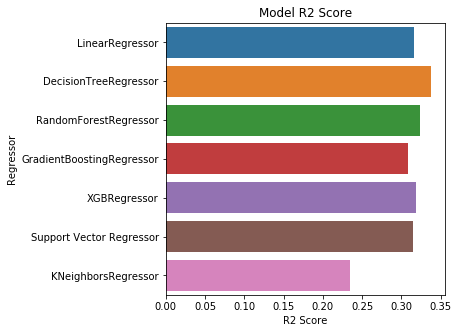

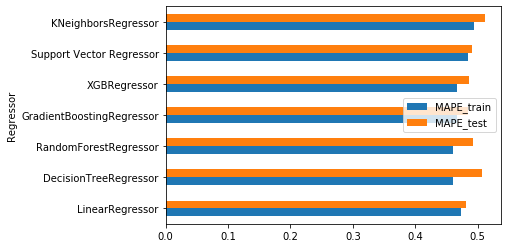

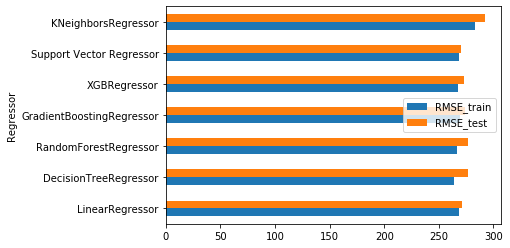

In [166]:
#Visualizing different metrics of the models
plt.figure(figsize = (5,5))
sns.barplot(data = model_data, x = model_data['R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')

model_data.plot(x = 'Regressor', y = ['MAPE_train', 'MAPE_test'], kind = 'barh')
model_data.plot(x = 'Regressor', y = ['RMSE_train', 'RMSE_test'], kind = 'barh')
plt.show()

In [170]:
# Making Final Prediction using all models
pre_df = pd.DataFrame()
data_new = data[X_cols]
pre_df['lr_pred'] = np.exp(model1.predict(data_new))
pre_df['dt_pred'] = np.exp(dt.predict(data_new))
pre_df['rf_pred'] = np.exp(rf.predict(data_new))
pre_df['gb_pred'] = np.exp(gb.predict(data_new))
pre_df['xgb_pred'] = np.exp(xgb.predict(data_new))
pre_df['svr_pred'] = np.exp(svr.predict(data_new))
pre_df['knn_pred'] = np.exp(knn.predict(data_new))
pre_df['avg_pred'] = pre_df[['lr_pred','dt_pred','rf_pred','gb_pred','xgb_pred','svr_pred','knn_pred']].apply(np.mean,axis=1)

final_data = pd.concat([data_new,data.total_spent,pre_df], axis = 1)

# Saving to excel
final_data.to_excel(output, 'Predicted Total Spent', index = False)

In [171]:
output.save()